# Exploratory data anaylsis

In [1]:
import pandas as pd



## Look at data and clean up one year

In [2]:
df = pd.read_excel("../notebooks/Historical Station Counts by State 2007-2021.xlsx", sheet_name='2020', skiprows=1)
df

,State,Biodiesel,CNG,E85,Electrica,Hydrogenb,LNG,Propanec,Totald
0,NaN,NaN,NaN,NaN,(stations / charging outlets,(retail / non-retail / total),NaN,(primary / secondary / total),NaN
1,NaN,NaN,NaN,NaN,Level 1 / Level 2 / DC Fast),NaN,NaN,NaN,NaN
2,Alabama,10.0,30.0,29.0,223 / 596,0 / 0 / 0,2.0,24 / 45 / 69,736.0
3,NaN,NaN,NaN,NaN,56 / 449 / 91,NaN,NaN,NaN,NaN
4,Alaska,0.0,1.0,0.0,25 / 45,0 / 0 / 0,0.0,1 / 2 / 3,49.0
...,...,...,...,...,...,...,...,...,...
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,(a) Includes legacy chargers but does not incl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,(b) Primary propane stations offer vehicle-spe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,(c) Retail hydrogen stations accept payment at...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df_cleaned = df.dropna(how="all")
    df_cleaned = df_cleaned.rename(columns={"Totald" : "Total"})
    df_cleaned = df_cleaned[["State", "Total"]]
    df_cleaned = df_cleaned.dropna()
    return df_cleaned

df_total = pd.DataFrame()
for n in range(2007, 2022, 1):
    df = pd.read_excel("../data/Historical Station Counts by State 2007-2021.xlsx", sheet_name=str(n), skiprows=1)
    df_cleaned = clean_data(df)
    df_cleaned["Year"] = n
    df_total = pd.concat([df_total, df_cleaned])

Get some general info about the data

In [3]:
df_total.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 2 to 104
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   State   780 non-null    object 
 1   Total   780 non-null    float64
 2   Year    780 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 24.4+ KB


In [5]:
df_total.describe(include='all')

,State,Total,Year
count,780,780.000000,780.000000
unique,52,NaN,NaN
top,Alabama,NaN,NaN
freq,15,NaN,NaN
mean,NaN,1802.579487,2014.000000
std,NaN,8917.620078,4.323266
min,NaN,6.000000,2007.000000
25%,NaN,112.000000,2010.000000
50%,NaN,294.500000,2014.000000
75%,NaN,969.250000,2018.000000


Check how many missing values we have

In [6]:
df_total.isna().mean()

State    0.0
Total    0.0
Year     0.0
dtype: float64

## Training a regression model on all data

In [4]:
from mlwrap.enums import AlgorithmType, DataType, FeatureType
from mlwrap.config import InputData, MLConfig, Feature, TrainingResults
from  mlwrap import runners

def train(df, features) -> TrainingResults:
    config = MLConfig(
                algorithm_type=AlgorithmType.SklearnLinearModel,
                features=features,
                model_feature_id="Total",
                input_data=InputData(data_type=DataType.DataFrame, data_frame=df),
            )
    return runners.train(config)

In [5]:
features = { 
        "Year" : Feature(id = "Year", feature_type=FeatureType.Continuous),
        "State" : Feature(id = "State", feature_type=FeatureType.Categorical),
        "Total" : Feature(id = "Total", feature_type=FeatureType.Continuous)
    }

df_train = df_total
results = train(df_train, features)
results.scores

{<ScoreType.iterations: 'iterations'>: 1,
 <ScoreType.total_row_count: 'total_row_count'>: 780,
 <ScoreType.active_feature_count: 'active_feature_count'>: 3,
 <ScoreType.inactive_feature_count: 'inactive_feature_count'>: 0,
 <ScoreType.mean_absolute_error: 'mean_absolute_error'>: 2272.8228,
 <ScoreType.median_absolute_error: 'median_absolute_error'>: 601.902,
 <ScoreType.mean_squared_error: 'mean_squared_error'>: 129517910.0}

Scores are better for states with lower counts if we train a model per state

<AxesSubplot:xlabel='Year'>

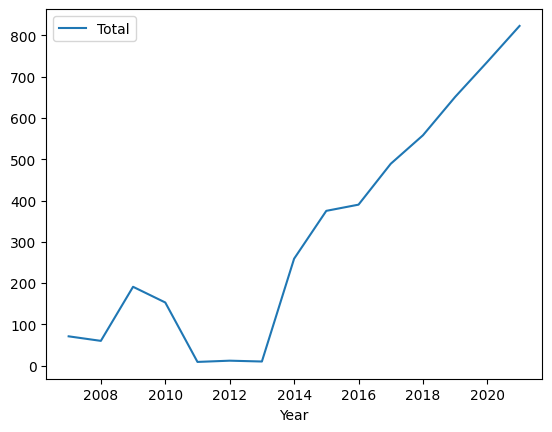

In [6]:
df_train_one_state = df_total.loc[df['State'] == 'Alabama']
df_train_one_state.plot(x="Year",y="Total")

In [7]:
results_one_state = train(df_train_one_state, features)
results_one_state.scores

/Users/rossparkin/Projects/ak/mlops-intro/.venv/lib/python3.9/site-packages/pandas/core/generic.py:7240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/Users/rossparkin/Projects/ak/mlops-intro/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


{<ScoreType.iterations: 'iterations'>: 1,
 <ScoreType.total_row_count: 'total_row_count'>: 15,
 <ScoreType.active_feature_count: 'active_feature_count'>: 2,
 <ScoreType.inactive_feature_count: 'inactive_feature_count'>: 1,
 <ScoreType.mean_absolute_error: 'mean_absolute_error'>: 197.59099,
 <ScoreType.median_absolute_error: 'median_absolute_error'>: 181.61633,
 <ScoreType.mean_squared_error: 'mean_squared_error'>: 42969.848}

## Add windows features

In [8]:
df_train_window = df_total.loc[df['State'] == 'California']
# df_train = df_train.loc[df_train["Total"] > 20]
df_train_window["TotalLastYear"] = df_train_window["Total"].shift(-1)
df_train_window["TotalNextYear"] = df_train_window["Total"].shift(1)
df_train_window = df_train_window.dropna()
# df_train.plot(x="Year",y="Total")
# df_train_window

/Users/rossparkin/Projects/ak/mlops-intro/.venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [9]:
features_with_window = { 
        "Year" : Feature(id = "Year", feature_type=FeatureType.Continuous),
        "State" : Feature(id = "State", feature_type=FeatureType.Categorical),
        "Total" : Feature(id = "Total", feature_type=FeatureType.Continuous),
        "TotalLastYear" : Feature(id = "TotalLastYear", feature_type=FeatureType.Continuous, active=True),
        "TotalNextYear" : Feature(id = "TotalNextYear", feature_type=FeatureType.Continuous, active=True)
    }
results_window = train(df_train_window, features_with_window)
results_window.scores

{<ScoreType.iterations: 'iterations'>: 1,
 <ScoreType.total_row_count: 'total_row_count'>: 13,
 <ScoreType.active_feature_count: 'active_feature_count'>: 4,
 <ScoreType.inactive_feature_count: 'inactive_feature_count'>: 1,
 <ScoreType.mean_absolute_error: 'mean_absolute_error'>: 274.66,
 <ScoreType.median_absolute_error: 'median_absolute_error'>: 153.24707,
 <ScoreType.mean_squared_error: 'mean_squared_error'>: 107720.37}

This works better but it introduces complexities when we think about how it would be implemented because it means that when making predicitions we need to know/guess TotalLastYear and TotalNextYear

## Make a prediction

In [10]:
def infer(df, features, training_results: TrainingResults):
    config = MLConfig(
                algorithm_type=AlgorithmType.SklearnLinearModel,
                features=features,
                model_feature_id="Total",
                input_data=InputData(data_type=DataType.DataFrame, data_frame=df),
            )
    config.input_data = InputData(data_type=DataType.DataFrame, data_frame=df)
    config.model_bytes = training_results.model_bytes
    config.encoder_bytes = training_results.encoder_bytes
    config.background_data_bytes = training_results.background_data_bytes
    return runners.infer(config)

df_predict = pd.DataFrame({"Year" : 2030}, index=[0])
inference_output = infer(df_predict, features, results_one_state)
inference_output.inference_results[0].values

[1144.994384765625]